**********************************************************************************************
## Multicomponent Potential Theory of Adsorption Implementation
**********************************************************************************************

This is the implementation of the MPTA model for binary mixtures.  

Version: 1.0  
Last Update: 2018-mar-02  
License: MIT  
Author: Raphaël Gervais Lavoie (raphael.gervaislavoie@uqtr.ca)  


If you find this code usefull, please cite the folowing reference:
> "Numerical implementation of the multicomponent potential theory of adsorption in Python using the NIST Refprop", 
 Raphaël Gervais Lavoie, Mathieu Ouellet, Jean Hamelin and Pierre Bénard,  
 Commun. Comput. Phys., Vol. 23, No. 5, 2018, pp. 1602--1625,  
 DOI: 10.4208/cicp.OA-2017-0012

In [225]:
### Importing relevant modules:
import numpy, scipy, lmfit, decimal, matplotlib.pyplot, refprop
%matplotlib inline

### All the relevent functions are define in the file "MPTA_Functions.py".
import MPTA_Functions_Binary_Mixtures as mpta

### Non essential modules:
import time

In [226]:
### If modification are made to the file "MPTA_Functions_Binary_Mixtures.py",
### it need to be reloaded with:
import importlib
importlib.reload(mpta)

<module 'MPTA_Functions_Binary_Mixtures' from '/home/rmachine/Documents/Python/MPTA/MPTA_Functions_Binary_Mixtures.py'>

In [227]:
### Refprop initialization and gas mixture definition:
refprop.setup(u'def', u'METHANE', u'CO2')

### Bulk mixture array:
xB = [0.80, 0.20]
X  = [[1, 0], [0, 1]]

T = 318.2

In [228]:
### Importing pure gases experimental data:
dataP_A = numpy.loadtxt('../Exp-data/Calgon-F400/Pure-Methane-run1.txt', dtype='float', usecols=[0])
dataAd_A = numpy.loadtxt('../Exp-data/Calgon-F400/Pure-Methane-run1.txt', dtype='float', usecols=[1])
dataP_B = numpy.loadtxt('../Exp-data/Calgon-F400/Pure-CO2-run1.txt', dtype='float', usecols=[0])
dataAd_B = numpy.loadtxt('../Exp-data/Calgon-F400/Pure-CO2-run1.txt', dtype='float', usecols=[1])

### Importing mixture experimental data:
dataP_MIX = numpy.loadtxt('../Exp-data/Calgon-F400/CH4_80--CO2_20.txt', dtype='float', usecols=[0])
dataRatio_A = numpy.loadtxt('../Exp-data/Calgon-F400/CH4_80--CO2_20.txt', dtype='float', usecols=[1])
dataAd_MIX_A = numpy.loadtxt('../Exp-data/Calgon-F400/CH4_80--CO2_20.txt', dtype='float', usecols=[2])
dataAd_MIX_B = numpy.loadtxt('../Exp-data/Calgon-F400/CH4_80--CO2_20.txt', dtype='float', usecols=[3])


### Experimental uncertainties on excess adsorption (in %):
Ad_Uncert_A     = 0.018
Ad_Uncert_B     = 0.064
Ad_Uncert_Mix   = 0.039
Ad_Uncert_Mix_A = 0.040
Ad_Uncert_Mix_B = 0.043

In [229]:
### Transforming experimental data of pressure into density:
dataD_A = []
for i in range(0, len(dataP_A)):
    d = scipy.optimize.fsolve(mpta.pressure, 1, args=(T, X[0], dataP_A[i]))
    dataD_A.append(float(d))

dataD_B = []
for i in range(0, len(dataP_B)):
    d = scipy.optimize.fsolve(mpta.pressure, 1, args=(T, X[1], dataP_B[i]))
    dataD_B.append(float(d))
    
dataD_MIX = []
for i in range(0, len(dataP_MIX)):
    d = scipy.optimize.fsolve(mpta.pressure, 1, args=(T, [dataRatio_A[i],1-dataRatio_A[i]], dataP_MIX[i]))
    dataD_MIX.append(float(d))

In [230]:
### Calculation of liquid density at dew point:
d_liq = []
for i in range(0,len(xB)):
    if T < refprop.info(icomp=i+1)['tcrit']:
        d_liq.append(refprop._abfl2('TD', T, 1, X[i])['Dliq'])
    else:
        d_liq.append(mpta.d_max(T, X[i]))

In [163]:
### Fitting the model to experimental data:
params = lmfit.Parameters()
params.add('z0', value=1, min=0, vary=True)
params.add('eps0_A', value=10000, min=0, vary=True)
params.add('eps0_B', value=10000, min=0, vary=True)
params.add('beta', value=2, min=0, max=10, vary=False)
start = time.time()
result = lmfit.minimize(mpta.mix_fit, params, args=(T, [dataD_A,dataD_B], [dataAd_A,dataAd_B], X, d_liq))
print(lmfit.fit_report(result))
end = time.time()
print('Fitting time(s):', end - start)

[[Fit Statistics]]
    # function evals   = 23
    # data points      = 24
    # variables        = 3
    chi-square         = 1.116
    reduced chi-square = 0.053
    Akaike info crit   = -67.633
    Bayesian info crit = -64.098
[[Variables]]
    z0:       0.30038830 +/- 0.005381 (1.79%) (init= 1)
    eps0_A:   7475.14089 +/- 230.1946 (3.08%) (init= 10000)
    eps0_B:   7767.40798 +/- 267.9494 (3.45%) (init= 10000)
    beta:     2 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(z0, eps0_B)                = -0.776 
    C(z0, eps0_A)                = -0.684 
    C(eps0_A, eps0_B)            =  0.530 
Fitting time(s): 132.44200730323792


In [231]:
### Fitted parameters values for pure gas:
fit_z0 = 0.30038830 #+/- 0.005381 (1.79%) (init= 1)
fit_eps0_A = 7475.14089 #+/- 230.1946 (3.08%) (init= 10000)
fit_eps0_B = 7767.40798 #+/- 267.9494 (3.45%) (init= 10000)
fit_beta = 2

In [232]:
### Compute the excess adsorption from the fitted values of the parameters for pure gas: 
dataFit_A = []
dataFit2_A = []
dataFit_B = []
dataFit2_B = []
Parray = numpy.linspace(1,1.1*max(max(dataP_A), max(dataP_B)),100)
Darray_A = []
Darray_B = []

for i in range(0, len(Parray)):
    d = scipy.optimize.fsolve(mpta.pressure, 1, args=(T, X[0], Parray[i]))
    Darray_A.append(float(d))
    d = scipy.optimize.fsolve(mpta.pressure, 1, args=(T, X[1], Parray[i]))
    Darray_B.append(float(d))

for i in range(0, len(dataD_A)):
    dataFit_A.append(mpta.N_ex_pure(T, fit_z0, fit_eps0_A, fit_beta, dataD_A[i], X[0], d_liq[0]))

for i in range(0, len(Darray)):
    dataFit2_A.append(mpta.N_ex_pure(T, fit_z0, fit_eps0_A, fit_beta, Darray_A[i], X[0], d_liq[0]))

for i in range(0, len(dataD_B)):
    dataFit_B.append(mpta.N_ex_pure(T, fit_z0, fit_eps0_B, fit_beta, dataD_B[i], X[1], d_liq[1]))

for i in range(0, len(Darray)):
    dataFit2_B.append(mpta.N_ex_pure(T, fit_z0, fit_eps0_B, fit_beta, Darray_B[i], X[1], d_liq[1]))

Exp_Uncert_B = Ad_Uncert_B*dataAd_B
Exp_Uncert_A = Ad_Uncert_A*dataAd_A

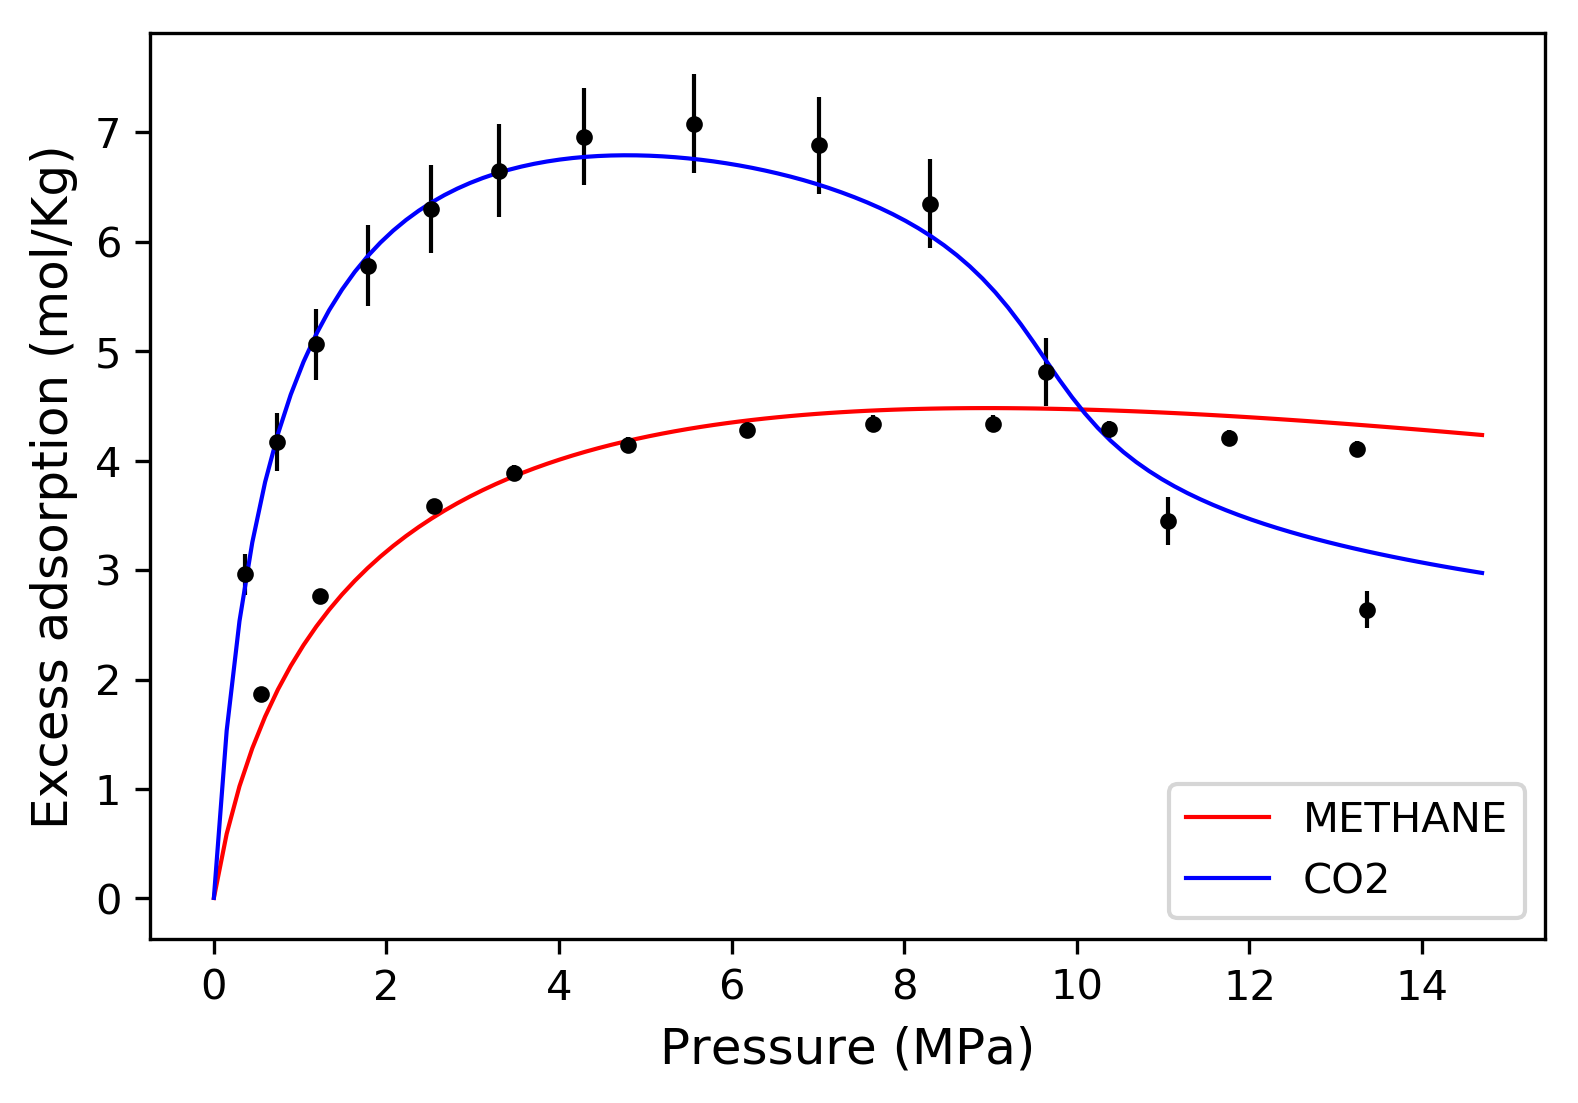

Mean error between experimental data and the model for pure METHANE :  4.6172142838 %
Mean error between experimental data and the model for pure CO2 :  4.51339649767 %


In [234]:
### Plot of the excess adsorption, fit vs. experimental:
fig = matplotlib.pyplot.figure(figsize=(6,4), dpi=300)
ax = fig.add_subplot(111)
ax.plot(Parray/1000,dataFit2_A,lw=1, label=refprop.info()['hfld'][0], color='red')
ax.plot(Parray/1000,dataFit2_B,lw=1, label=refprop.info()['hfld'][1], color='blue')
matplotlib.pyplot.xlabel('Pressure (MPa)', fontsize=12)
matplotlib.pyplot.ylabel('Excess adsorption (mol/Kg)', fontsize=12)
matplotlib.pyplot.errorbar(dataP_A/1000, dataAd_A, yerr=Exp_Uncert_A, fmt='k.', lw=1)
matplotlib.pyplot.errorbar(dataP_B/1000, dataAd_B, yerr=Exp_Uncert_B, fmt='k.', lw=1)
matplotlib.pyplot.legend(loc='lower right')
matplotlib.pyplot.show()

print('Mean error between experimental data and the model for pure',refprop.info()['hfld'][0],': ', mpta.mean_error(dataAd_A,dataFit_A), '%')
print('Mean error between experimental data and the model for pure',refprop.info()['hfld'][1],': ', mpta.mean_error(dataAd_B,dataFit_B), '%')

In [200]:
### Compute the density and molar fraction profile of the mixture in the 
### adsorbed phase for the given bulk density:
BulkDensity = 0.5     #(in mol/L)
Z = numpy.linspace(0,1,num=1000)
DensityProfile_A = []
DensityProfile_B = []
DensityProfile_Mix = []
MolarFractionProfile_A = []
MolarFractionProfile_B = []
d0 = BulkDensity
x0 = xB

for i in range(0, len(Z)):
    [d, x] = mpta.d_mix(Z[i]*fit_z0, T, fit_z0, [fit_eps0_A, fit_eps0_B], fit_beta, BulkDensity, xB, d0, x0, X, d_liq)
    DensityProfile_A.append(d*x)
    DensityProfile_B.append(d*(1-x))
    DensityProfile_Mix.append(d)
    MolarFractionProfile_A.append(x)
    MolarFractionProfile_B.append(1-x)
    d0 = d
    x0 = [x, 1-x]
    

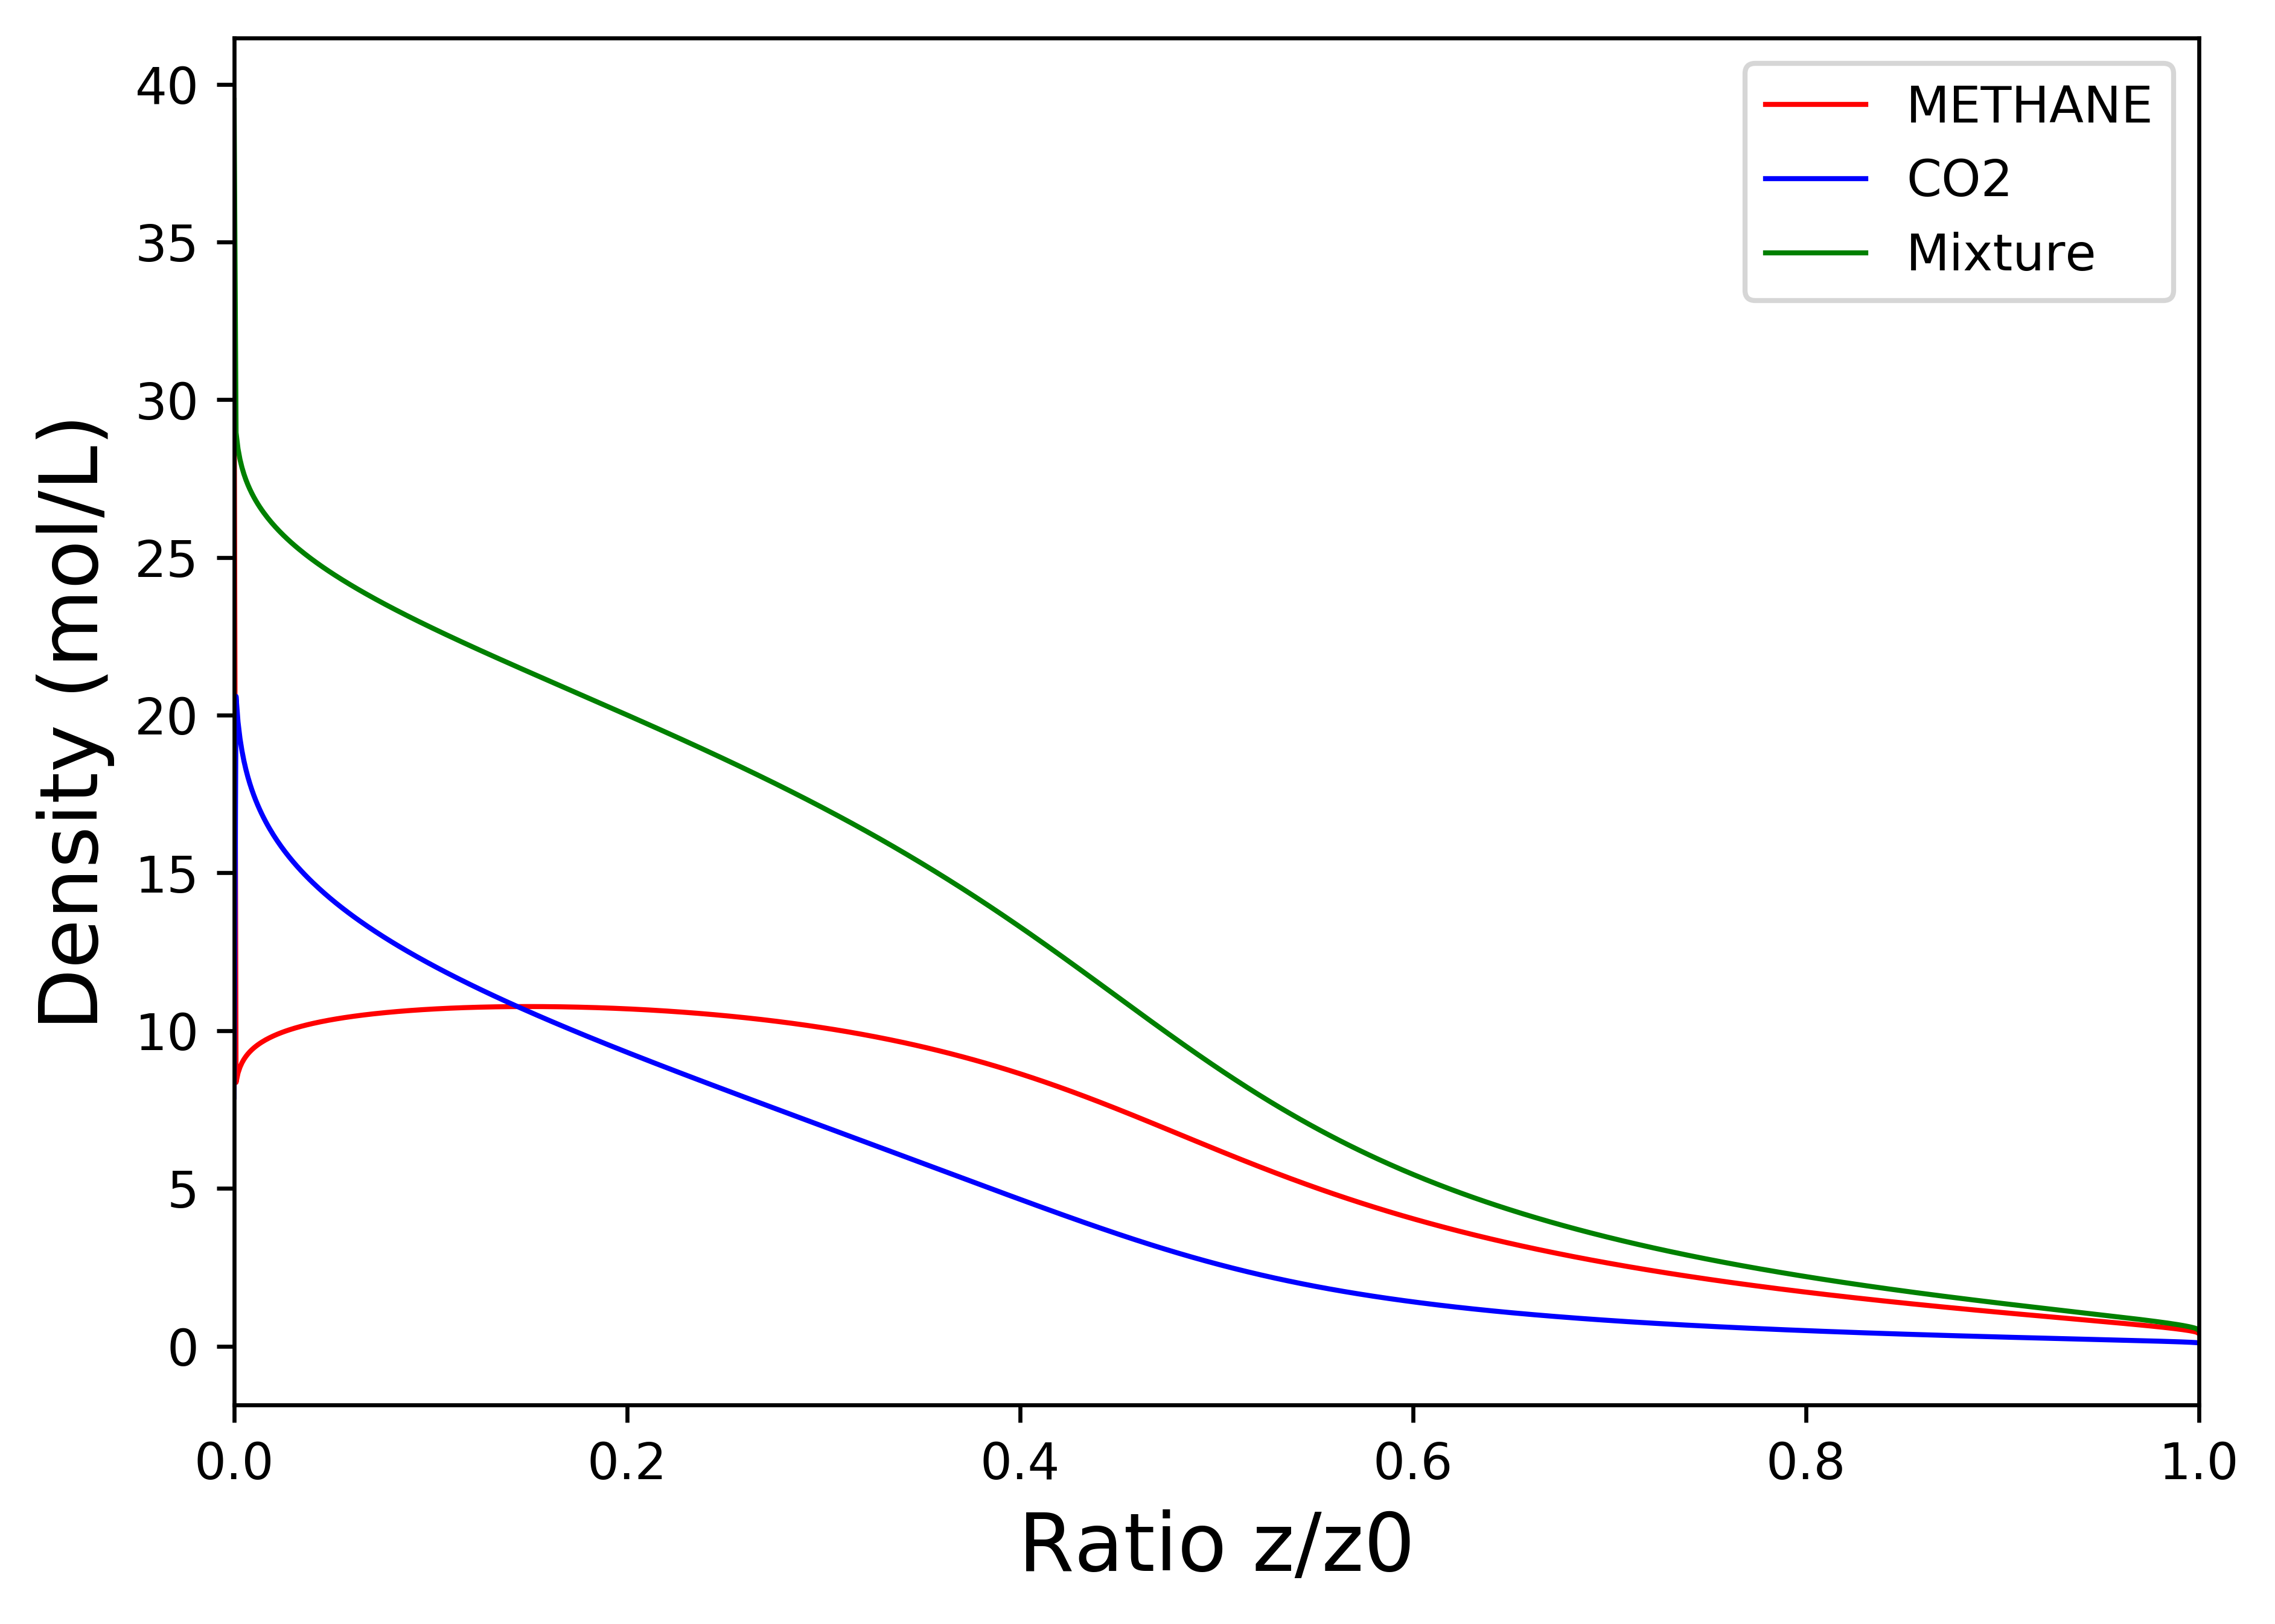

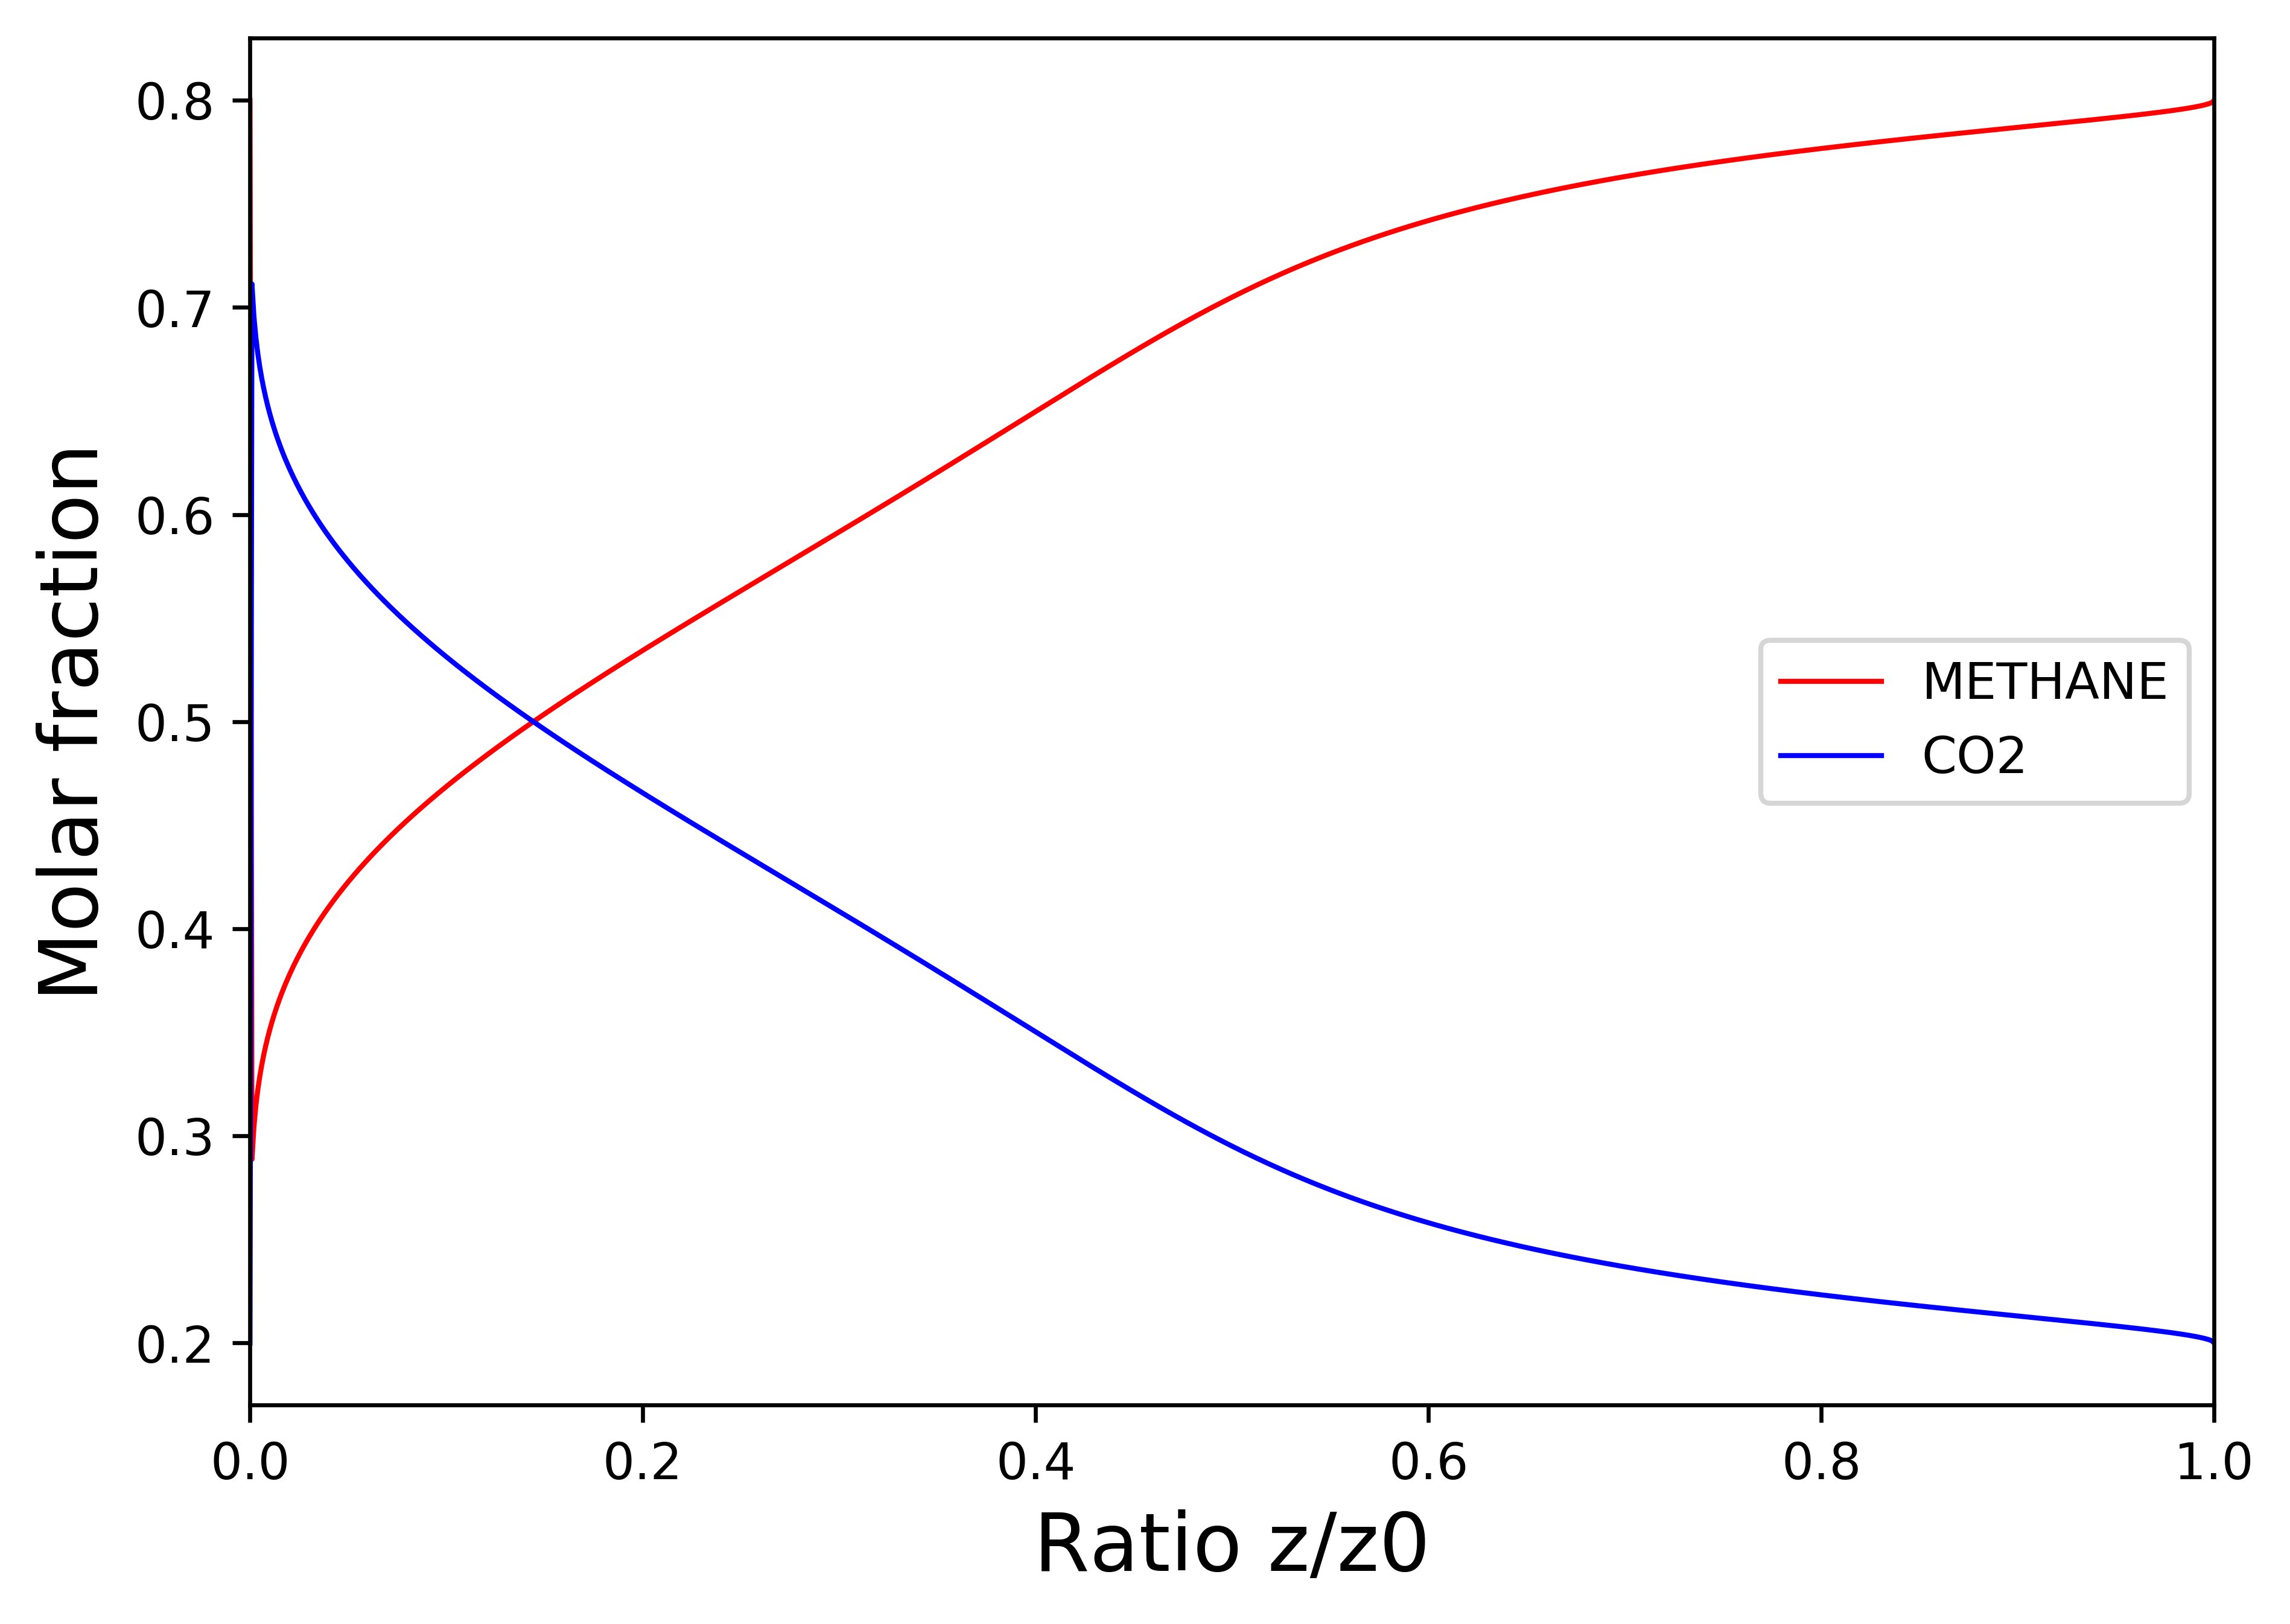

In [223]:
### Plot of the adsorbed phase density profile:
fig = matplotlib.pyplot.figure(figsize=(7,5), dpi=600)
ax = fig.add_subplot(111)
ax.plot(Z,DensityProfile_A, lw=1, linestyle='-', label=refprop.info()['hfld'][0], color='red')
ax.plot(Z,DensityProfile_B, lw=1, linestyle='-', label=refprop.info()['hfld'][1], color='blue')
ax.plot(Z,DensityProfile_Mix, lw=1, linestyle='-', label='Mixture', color='green')
ax.legend(loc='upper right')
matplotlib.pyplot.xlabel('Ratio z/z0', fontsize=16)
matplotlib.pyplot.ylabel('Density (mol/L)', fontsize=16)
ax.set_xlim([0,1])
matplotlib.pyplot.show()

### Plot of the adsorbed phase molar fraction profile:
fig = matplotlib.pyplot.figure(figsize=(7,5), dpi=600)
ax = fig.add_subplot(111)
ax.plot(Z,MolarFractionProfile_A, lw=1, linestyle='-', label=refprop.info()['hfld'][0], color='red')
ax.plot(Z,MolarFractionProfile_B, lw=1, linestyle='-', label=refprop.info()['hfld'][1], color='blue')
ax.legend(loc='center right')
matplotlib.pyplot.xlabel('Ratio z/z0', fontsize=16)
matplotlib.pyplot.ylabel('Molar fraction', fontsize=16)
ax.set_xlim([0,1])
matplotlib.pyplot.show()

In [240]:
### Compute the excess adsorption from the fitted values of the parameters for pure gas: 
dataFit_MIX_A = []
dataFit_MIX_B = []
dataFit_MIX = []
    
for i in range(0, len(dataD_MIX)):
    [n1, n2] = mpta.N_ex_mix(T, fit_z0, [fit_eps0_A,fit_eps0_B], fit_beta, dataD_MIX[i], [dataRatio_A[i],1-dataRatio_A[i]], X, d_liq)
    dataFit_MIX_A.append(n1)
    dataFit_MIX_B.append(n2)
    dataFit_MIX.append(n1+n2)


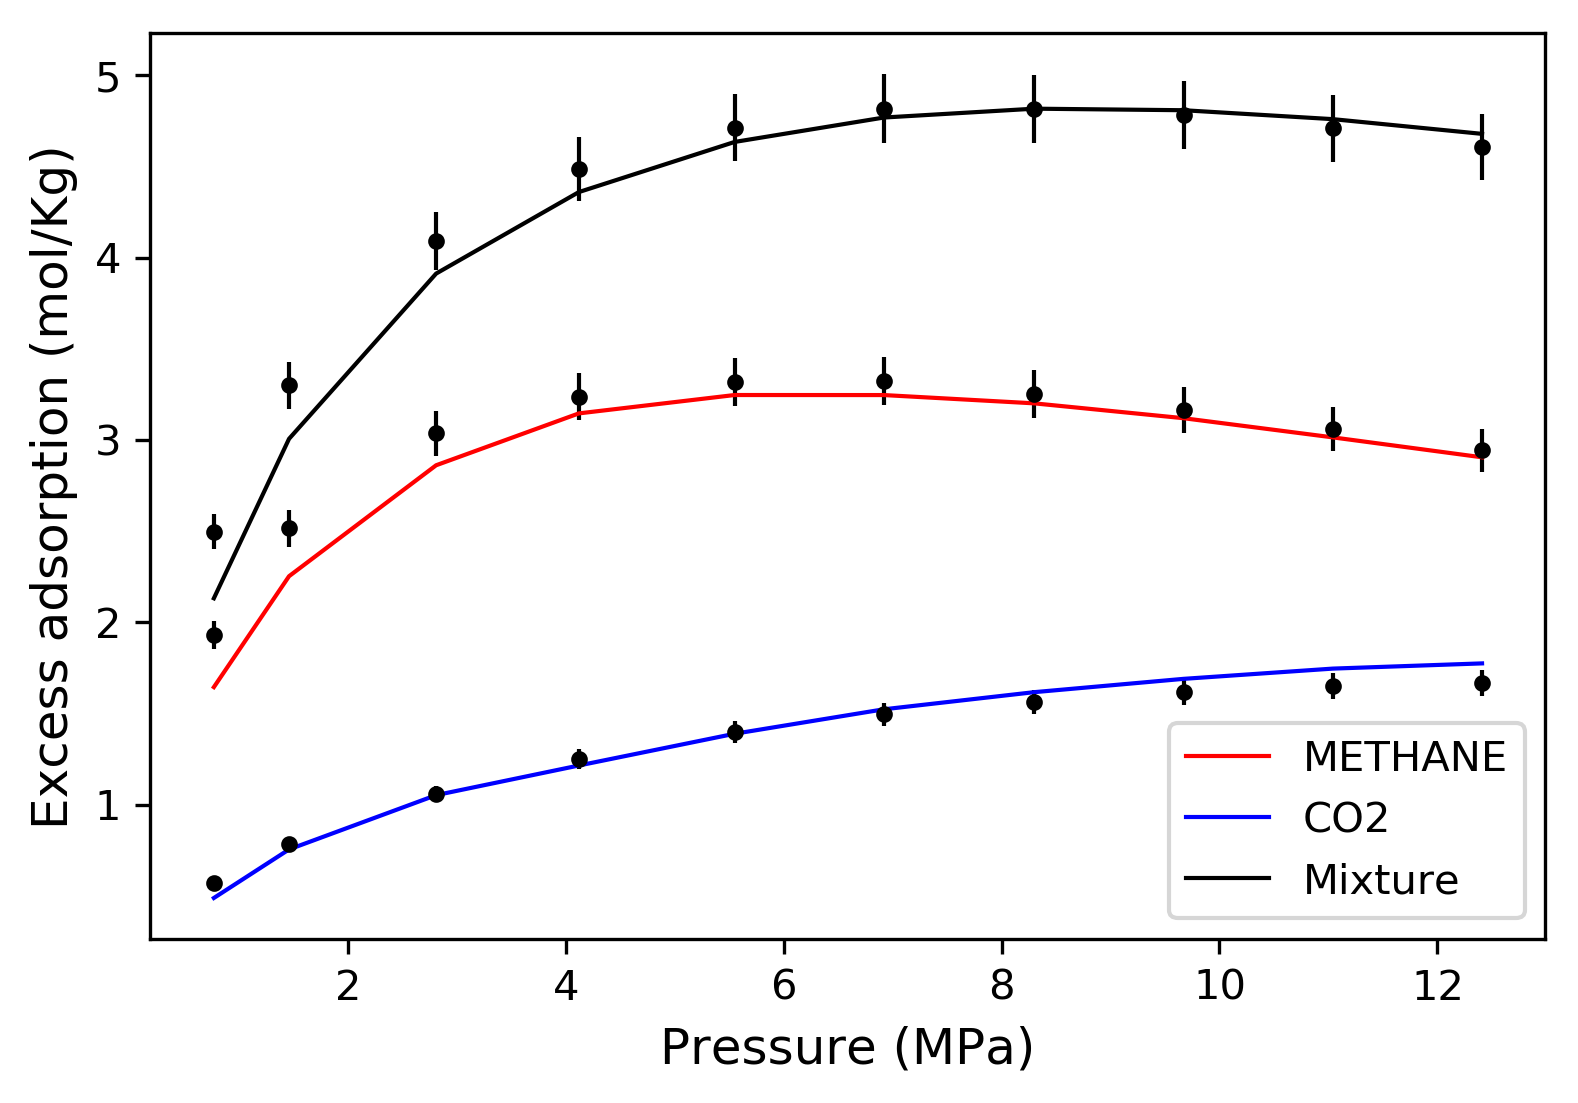

Mean error between experimental data and the model for METHANE :  4.41966942969 %
Mean error between experimental data and the model for CO2 :  4.41262747763 %
Mean error between experimental data and the model for the mixture:  3.66743022086 %


In [241]:
### Plot of the excess adsorption, fit vs. experimental:
dataAd_MIX = numpy.add(dataAd_MIX_A, dataAd_MIX_B)

fig = matplotlib.pyplot.figure(figsize=(6,4), dpi=300)
ax = fig.add_subplot(111)
ax.plot(dataP_MIX/1000,dataFit_MIX_A,lw=1, label=refprop.info()['hfld'][0], color='red')
ax.plot(dataP_MIX/1000,dataFit_MIX_B,lw=1, label=refprop.info()['hfld'][1], color='blue')
ax.plot(dataP_MIX/1000,dataFit_MIX,lw=1, label='Mixture', color='black')
matplotlib.pyplot.xlabel('Pressure (MPa)', fontsize=12)
matplotlib.pyplot.ylabel('Excess adsorption (mol/Kg)', fontsize=12)
matplotlib.pyplot.errorbar(dataP_MIX/1000, dataAd_MIX_A, yerr=Ad_Uncert_Mix_A*dataAd_MIX_A, fmt='k.', lw=1)
matplotlib.pyplot.errorbar(dataP_MIX/1000, dataAd_MIX_B, yerr=Ad_Uncert_Mix_B*dataAd_MIX_B, fmt='k.', lw=1)
matplotlib.pyplot.errorbar(dataP_MIX/1000, dataAd_MIX, yerr=Ad_Uncert_Mix*dataAd_MIX, fmt='k.', lw=1)
matplotlib.pyplot.legend(loc='lower right')
matplotlib.pyplot.show()

print('Mean error between experimental data and the model for',refprop.info()['hfld'][0],': ', mpta.mean_error(dataAd_MIX_A, dataFit_MIX_A), '%')
print('Mean error between experimental data and the model for',refprop.info()['hfld'][1],': ', mpta.mean_error(dataAd_MIX_B, dataFit_MIX_B), '%')
print('Mean error between experimental data and the model for the mixture: ', mpta.mean_error(dataAd_MIX, dataFit_MIX), '%')